In [0]:
from fastai import *
from fastai.text import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#vocabulario
with open('drive/My Drive/PT_LM/models/pt_wt_vocab.pkl', 'rb') as f:
    itos = pickle.load(f)
vocab = Vocab(itos)

In [5]:
df_train = pd.read_csv('base_treino.csv',sep='|',encoding='utf-8')
df_train.head()

,Arquivo,indicacao,indication,ATC_1,ATC_2,ATC_3,ATC_4
0,bula2179,Este pomada é indicada para o alívio das manif...,This ointment is indicated for the relief of i...,D,D07,D07B,D07B1
1,bula96,Replenine-VF é indicado no tratamento de episó...,Replenine-VF is indicated for the treatment of...,B,B02,B02D,B02D2
2,bula1835,Hipertensão captopril é indicado para o tratam...,Hypertension Captopril is indicated for the tr...,C,C09,C09A,C09A0
3,bula1590,Transpulmin xarope é um expectorante destinado...,Transpulmin syrup is an expectorant intended f...,R,R05,R05C,R05C0
4,bula4244,Dutasterida trata e previne a progressão da hi...,Dutasterida treats and prevents the progressio...,G,G04,G04C,G04C3


In [6]:
df_valid= pd.read_csv('base_teste.csv',sep='|',encoding='utf-8')
df_valid.head()

,Arquivo,indicacao,indication,ATC_1,ATC_2,ATC_3,ATC_4
0,bula292,Cloridrato de ranitidina é indicado no tratame...,Hydrochloride Ranitidina is indicated for the ...,A,A02,A02B,A02B1
1,bula7742,"Hipercolesterolemia Primária ezetimiba, admini...","Primary Hypercholesterolaemia ezetimibe, admin...",C,C10,C10A,C10A9
2,bula2854,SURVANTAr beractanto é destinado à prevenção e...,SURVANTAr Beractant is intended for the preven...,R,R07,R07C,R07C0
3,bula2326,GASTROBENE está indicado para - distúrbios da ...,GASTROBENE is indicated for-disorders of gastr...,A,A03,A03F,A03F0
4,bula3390,Hidrofluxr é destinado ao tratamento da hipert...,HYDROFLUXR is intended for the treatment of ar...,C,C03,C03A,C03A3


In [0]:
data_lm = TextLMDataBunch.from_df('drive/My Drive/PT_LM',train_df=df_train,valid_df=df_valid,text_cols='indicacao',label_cols='ATC_1',vocab=vocab)

In [8]:
data_lm.show_batch()

idx,text
0,"xxunk , dermatite solar , dermatite de xxunk e prurido xxunk . xxbos xxmaj xxunk - xxup xxunk é indicado no tratamento de episódios xxunk e na manutenção de níveis xxunk de fator xxup ix , em pacientes diagnosticados com hemofilia xxup b. xxbos xxmaj hipertensão xxunk é indicado para o tratamento da hipertensão , por reduzir a pressão arterial nesses casos . xxmaj insuficiência xxmaj cardíaca xxunk é indicado"
1,"xxmaj diagnóstica da xxmaj xxunk xxmaj xxunk . xxbos xxmaj este medicamento é indicado como analgésico e xxunk . xxbos xxmaj este medicamento é destinado ao tratamento de xxunk xxunk intestinal sob todas as formas xxunk hepática xxunk . xxbos xxmaj xxunk creme é indicado para o tratamento de xxunk causadas por xxunk , leveduras , xxunk , etc . por ex . xxmaj xxunk xxunk , xxmaj xxunk xxunk"
2,"trato respiratório inferior . xxbos a vacina febre amarela atenuada é utilizada na prevenção da febre amarela , doença causada por um xxunk da família xxmaj xxunk , do gênero xxmaj xxunk . é recomendada para vacinação em áreas endêmicas ou xxunk ou para os viajantes que a elas se destinam . xxbos xxmaj xxunk está indicado para tratamento local de infecções xxunk xxunk causadas por xxmaj xxunk xxunk ."
3,xxunk e xxunk posterior difusa xxunk simpática conjuntivite alérgica xxunk xxunk xxunk óptica xxunk e xxunk . - xxmaj doenças xxmaj respiratórias xxmaj xxunk xxunk xxmaj síndrome de xxmaj xxunk não - xxunk por outros meios xxunk tuberculose pulmonar fulminante ou disseminada quando usado concomitantemente à quimioterapia xxunk apropriada xxunk por aspiração asma xxunk . - xxmaj distúrbios xxmaj xxunk xxmaj púrpura xxunk idiopática em adultos xxunk secundária em adultos
4,", acne xxunk , xxunk , xxunk , estomatite angular , dermatite por xxunk , xxunk xxunk xxunk e infecções xxunk por xxunk , como xxmaj xxunk xxunk , xxmaj xxunk xxunk e xxmaj xxunk xxunk . xxbos xxmaj xxunk creme deve ser usado para o tratamento dos seguintes tipos de xxunk xxmaj tinha dos pés plantar e xxunk xxmaj tinha xxunk xxmaj outras xxunk tinha do corpo e tinha"


In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM,pretrained_fnames=['pt_wt', 'pt_wt_vocab'], 
                               drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


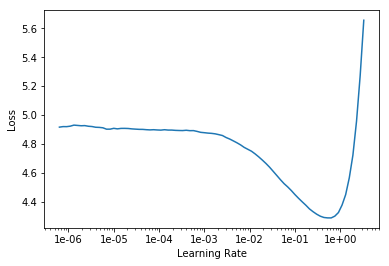

In [10]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [11]:
max_lr = 8e-2
learn_lm.fit_one_cycle(30, max_lr=max_lr, moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn_lm, every='improvement', monitor='accuracy', name='learn_lm')])

epoch,train_loss,valid_loss,accuracy,time
0,3.361367,2.849180,0.398741,01:19
1,2.652474,2.331912,0.474384,01:19
2,2.246097,2.047657,0.529312,01:19
3,1.996406,1.919663,0.559589,01:19
4,1.929657,1.909979,0.562348,01:19
5,1.874929,1.887290,0.573179,01:19
6,1.881621,1.908357,0.571170,01:19
7,1.880330,1.900922,0.573768,01:19
8,1.858890,1.925862,0.574857,01:19
9,1.850060,1.898765,0.583277,01:19


Better model found at epoch 0 with accuracy value: 0.39874106645584106.
Better model found at epoch 1 with accuracy value: 0.4743839502334595.
Better model found at epoch 2 with accuracy value: 0.5293124914169312.
Better model found at epoch 3 with accuracy value: 0.5595892667770386.
Better model found at epoch 4 with accuracy value: 0.5623482465744019.
Better model found at epoch 5 with accuracy value: 0.5731785297393799.
Better model found at epoch 7 with accuracy value: 0.5737678408622742.
Better model found at epoch 8 with accuracy value: 0.5748570561408997.
Better model found at epoch 9 with accuracy value: 0.5832768678665161.
Better model found at epoch 10 with accuracy value: 0.590276837348938.
Better model found at epoch 11 with accuracy value: 0.5976428389549255.
Better model found at epoch 12 with accuracy value: 0.6011428236961365.
Better model found at epoch 13 with accuracy value: 0.6073482632637024.
Better model found at epoch 14 with accuracy value: 0.6171696186065674.
B

In [0]:
#Carrego a melhor versão do language model
learn_lm.load('learn_lm')
learn_lm.save_encoder('enc')

In [0]:
data_clas = TextClasDataBunch.from_df('.',train_df=df_train,valid_df=df_valid,text_cols='indicacao',label_cols='ATC_1')
data_clas.save('data_clas')

In [0]:
data_clas.show_batch()

In [0]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3, callback_fns=ShowGraph)
learn_clas.load_encoder('enc')

In [0]:
learn_clas.lr_find()
learn_clas.recorder.plot()

In [0]:
max_lr = 3e-2
learn_clas.fit_one_cycle(70, max_lr=max_lr , moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn_clas, every='improvement', monitor='accuracy', name='learn_clas')])

In [0]:
learn_clas.load('learn_clas')

In [0]:
interp = ClassificationInterpretation.from_learner(learn_clas)

In [0]:
interp.plot_confusion_matrix(figsize=(14,14), dpi=60)